In [1]:
from os.path import join as jn
import shelve

import numpy as np
import networkx as nx
from tqdm.notebook import tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

import EMB

ROOT = jn("..", "..", "")
DATA = jn(ROOT, "data", "")
FIGURES = jn(ROOT, "results", "figures", "")

In [2]:
shelf = shelve.open(jn(DATA, "data_size-effect-transition.shelf"))

for N in tqdm_notebook(np.linspace(100, 10_000, num=100)):
    if shelf.get(str(N), None) is not None:
        print(f"Data exists in shelf, skipping this value of N (N={N})!")
        continue

    # 1 Generate duplex
    G = EMB.netsci.models.benchmarks.generate_network_LFR(
            N, 2.1, 1.0, 0.1, 6, 32, 1, ROOT
    )[0]
    H = EMB.netsci.models.benchmarks.generate_network_LFR(
            N, 2.1, 1.0, 0.1, 6, 32, 1, ROOT
    )[0]

    D = dict(enumerate(EMB.netsci.models.preprocessing.make_layers_disjoint(G, H)))

    # 2 Observe remnants
    remnant_multiplex = EMB.remnants.observer.random_observations_multiplex(D, 0.3)
    remnant_multiplex = EMB.remnants.observer.build_remnant_multiplex(D, remnant_multiplex)

    # 3 Embed multiplex
    vectors = EMB.embeddings.embed_multiplex_LE(remnant_multiplex, k=128)

    # 4 Calculate features
    testing_edges = remnant_multiplex[-1].edges()
    training_edges = EMB.netsci.all_edges(*remnant_multiplex.values()) - set(testing_edges)
    y_train = {edge: EMB.netsci.find_edge(edge, *D.values())[0] for edge in training_edges}
    y_test = {edge: EMB.netsci.find_edge(edge, *D.values())[0] for edge in testing_edges}
    remnant_multiplex = EMB.utils.cutkey(remnant_multiplex, -1)
    components = {
        label: sorted(nx.connected_components(graph))
        for label, graph in remnant_multiplex.items()
    }
    vectors = EMB.utils.cutkey(vectors, -1)
    for label, vectorset in vectors.items():
        node2id = dict()
        vectors[label] = EMB.embeddings.normalize_vectors(vectorset, components[label], node2id=node2id)
    training_distances = EMB.classifiers.get_distances_feature(vectors.values(), training_edges, training=True)
    testing_distances = EMB.classifiers.get_distances_feature(vectors.values(), testing_edges, training=False)
    training_degrees = EMB.classifiers.get_degrees_feature(remnant_multiplex.values(), training_edges, training=True)
    testing_degrees = EMB.classifiers.get_degrees_feature(remnant_multiplex.values(), testing_edges, training=False)
    X_train = np.array([training_distances, training_degrees]).transpose()
    X_test = np.array([testing_distances, testing_degrees]).transpose()

    # 5 Train model
    model = EMB.classifiers.train_model(X_train, list(y_train.values()))

    # 6 Retrieve coefficient relation
    dists, degs = model.coef_[0]
    rel_dists = abs(dists) / (abs(dists) + abs(degs))

    # 7 Add evaluation to records
    shelf[str(N)] = rel_dists

shelf.close()

  0%|          | 0/100 [00:00<?, ?it/s]

Data exists in shelf, skipping this value of N (N=100.0)!
Data exists in shelf, skipping this value of N (N=200.0)!
Data exists in shelf, skipping this value of N (N=300.0)!
Data exists in shelf, skipping this value of N (N=400.0)!
Data exists in shelf, skipping this value of N (N=500.0)!
Data exists in shelf, skipping this value of N (N=600.0)!
Data exists in shelf, skipping this value of N (N=700.0)!
Data exists in shelf, skipping this value of N (N=800.0)!
Data exists in shelf, skipping this value of N (N=900.0)!
Data exists in shelf, skipping this value of N (N=1000.0)!
Data exists in shelf, skipping this value of N (N=1100.0)!
Data exists in shelf, skipping this value of N (N=1500.0)!
Data exists in shelf, skipping this value of N (N=2000.0)!
Data exists in shelf, skipping this value of N (N=2500.0)!
Data exists in shelf, skipping this value of N (N=3000.0)!
Data exists in shelf, skipping this value of N (N=3500.0)!
Data exists in shelf, skipping this value of N (N=4000.0)!
Data e

In [ ]:
with shelve.open(jn(DATA, "data_size-effect-transition.shelf")) as shelf:
    records = {key: value for key, value in shelf.items()}

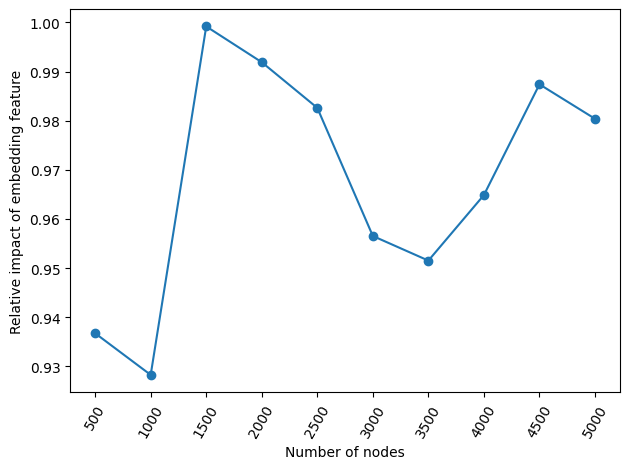

In [ ]:
plt.figure()

x = []
y = []
for n, r in sorted(records.items(), key=lambda x: int(float(x[0]))):
    x.append(int(float(n)))
    y.append(r)

plt.plot(
    x, y,
    marker="o")

plt.xticks(x, rotation=60)
plt.xlabel("Number of nodes")
plt.ylabel("Relative impact of embedding feature")

# plt.title("")
plt.tight_layout()
# plt.savefig(jn(FIGURES, "figure_relcoef-size_data-LFR.png"), transparent=False, facecolor="white")